In [1]:
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel,Field
from typing import TypedDict,List,Optional,Annotated
from utils.schema import State

In [2]:
#agent imports
from agents.universal_naming_agent import universal_name_refiner_v4
from agents.universal_parser_agent import parser_graph
from agents.db_hooks import check_doc_with_name_version
    

d:\smart_search_fino\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\smart_search_fino\.venv\lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
def routing_to_parsing(state:State):
    revision_tag = state['revision_tag']
    if not revision_tag is None:
        filename = state['normalized_filename']
        version_no = state['version']
        is_present = check_doc_with_name_version(filename,version_no)
        
        if is_present:
            return "end"
        else:
            return "parsing_agent"
    return "parsing_agent"
    

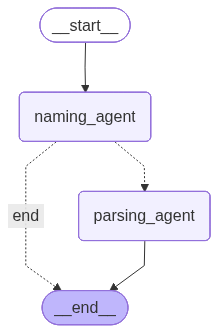

In [4]:
builder = StateGraph(State)

builder.add_node("naming_agent",universal_name_refiner_v4)
builder.add_node("parsing_agent",parser_graph)

builder.add_edge(START,"naming_agent")

builder.add_conditional_edges(
    "naming_agent",
    routing_to_parsing,
    {
        "parsing_agent":"parsing_agent",
        "end":END
    }
)

builder.add_edge("parsing_agent",END)

graph = builder.compile()

graph


In [ ]:
final = graph.invoke({"original_filename":"Citizens Charter.pdf"})
final

{'original_filename': 'revised_shrut_v001.pdf',
 'normalized_filename': 'shrut_v1_revised.pdf',
 'version': 'v1',
 'revision_tag': 'revised',
 'is_collision': False,
 'confidence': 0.98,
 'version_detected': True}